# 0. Imports

In [1]:
import os
os.chdir('./dash_interface/')

In [2]:
from my_dash_components import ScatterplotComponent, LinearplotComponent, HistogramplotComponent
from dash import dcc, html, Input, Output
import pandas as pd
from jupyter_dash import JupyterDash

In [3]:
hostId = 0
def getHost():
    global hostId
    hostId += 1
    return '127.0.0.' + str(hostId)

# 1. Gráfico customizado com widget do dash 

In [4]:
filename =  '../web3/data.tsv'
iris = pd.read_csv(filename,sep="\t")
iris_array_of_dicts = iris.to_dict(orient='records')

app = JupyterDash(__name__)

app.layout = html.Div([
    ScatterplotComponent(
        id='input',
        data=iris_array_of_dicts
    ),
    dcc.RangeSlider(
        id='range-slider',
        min=0, max=2.5, step=0.1,
        marks={0: '0', 2.5: '2.5'},
        value=[0.5, 2]
    ),
])

@app.callback(
    Output("input", "data"), 
    Input("range-slider", "value"))
def update_bar_chart(value):
    low, high = value
    mask = (iris['petalWidth'] > low) & (iris['petalWidth'] < high)
    res = iris[mask].to_dict(orient='records')
    return res

if __name__ == '__main__':
    app.run_server(mode="jupyterlab", host=getHost())


# 2. Pdp com histograma

In [33]:
path = '../data/bike.csv'
df = pd.read_csv(path)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [34]:
num_features = ['temp', 'hum', 'windspeed']
X = df[num_features]
y = df['cnt']
feature = 0

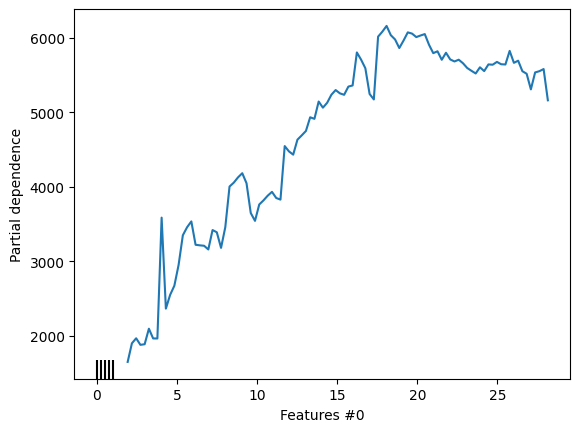

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=10).fit(X, y)
features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}
pd_results = partial_dependence(
    clf, X, features=feature, kind="average")
display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot()

plt.show()

In [36]:
pd_results.keys()

dict_keys(['grid_values', 'values', 'average'])

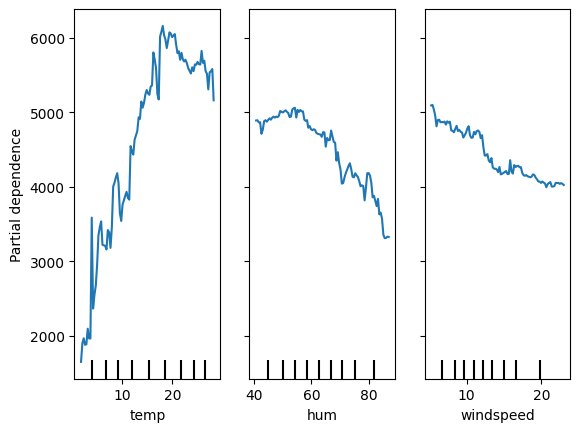

In [37]:
features = [0,1,2]
PartialDependenceDisplay.from_estimator(clf, X, features)

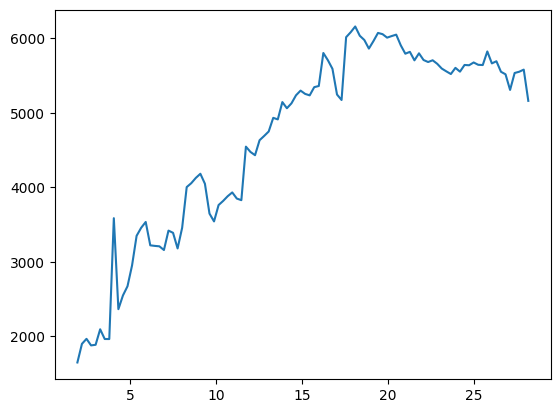

In [38]:
plt.plot(pd_results['grid_values'][0], pd_results['average'][0])
plt.show()

In [39]:
import seaborn as sns

<Axes: xlabel='temp', ylabel='Count'>

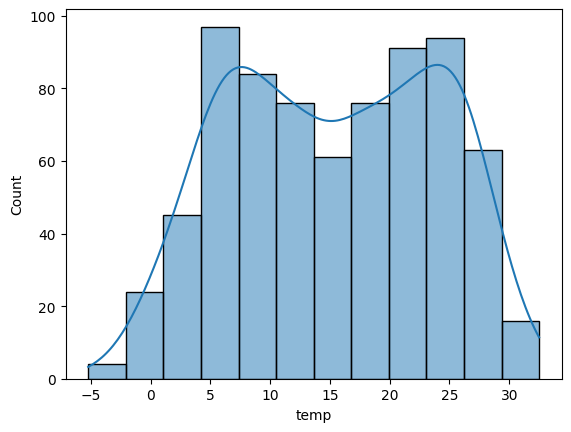

In [40]:
sns.histplot(df[num_features[feature]], kde=True)

In [41]:
pdp_df = pd.DataFrame({'grid_values': pd_results['grid_values'][0], 'average': pd_results['average'][0]})
pdp_dict = pdp_df.to_dict(orient='records')
x_start = min(df[num_features[feature]].min(), pdp_df['grid_values'].min())
x_end = max(df[num_features[feature]].max(), pdp_df['grid_values'].max())

In [42]:
app = JupyterDash(__name__)

app.layout = html.Div([
    LinearplotComponent(
        id='linear',
        data=pdp_dict,
        x_axis='grid_values',
        y_axis='average',
        xStart=x_start,
        xEnd=x_end,
    ),
    HistogramplotComponent(
        id='hist',
        data=df.to_dict(orient='records'),
        value=num_features[feature],
        xStart=x_start,
        xEnd=x_end,
    ),
    html.Div(id='output')
])

clickedValue = ""
@app.callback(
    Output("output", "children"), 
    Input("linear", "value"))
def showDataPoint(value):
    global clickedValue
    clickedValue = value
    return value

if __name__ == '__main__':
    app.run_server(mode="jupyterlab", host=getHost())

In [44]:
clickedValue

'x:8.8  -  y:4125.5'